# <center>**Classification of 10 Categories of Animals**</center>

Setup

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint

1. Loading data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 Extracting data

In [2]:
!pwd

/c/Users/agbad/OneDrive/Desktop/vick/Data_j/DataProjects/animal_classification


In [3]:
folders = os.listdir('2/raw-img')

categories = [] # list of all ten categories present in the data
files = [] # list of all files in all categories

for k, folder in enumerate(folders):
    foldernames = os.listdir('2/raw-img/' + folder)
    for file in foldernames:
        files.append('2/raw-img/' + folder + '/' + file)
        categories.append(k)

df = pd.DataFrame({'imagefile': files, 'category': categories})
df.head()

,imagefile,category
0,2/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0
1,2/raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS....,0
2,2/raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA....,0
3,2/raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....,0
4,2/raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   imagefile  26179 non-null  object
 1   category   26179 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 409.2+ KB


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 Define training data

In [5]:
# collect 500 samples from each category to make the training data 
train_data = df.groupby('category').apply(lambda x: x.sample(1000)).reset_index(drop=True)

print(train_data.category.value_counts(), "\n")
print(train_data)

category
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64 

                                              imagefile  category
0     2/raw-img/cane/OIP-wcQB750wir-_nCtBgiXdFQHaHa....         0
1     2/raw-img/cane/OIP-c7GQ5CUHx7uFPPpFWcKy1AHaFj....         0
2     2/raw-img/cane/OIP-MtnPu8q8owg9PT8-BOmYLQHaE7....         0
3     2/raw-img/cane/OIP-mG2X_Fqwb4aL6WEpsYqjyQHaFf....         0
4     2/raw-img/cane/OIP-BIL1SNCm_Xo9xgeUgEQxMAHaFf....         0
...                                                 ...       ...
9995  2/raw-img/scoiattolo/OIP-hN0GZKl7aACeEjc74RdHK...         9
9996  2/raw-img/scoiattolo/OIP-5F450oeIrWqLpbhpjJIpg...         9
9997  2/raw-img/scoiattolo/OIP-bYm0_Rt83Sk59gLeaPFcL...         9
9998  2/raw-img/scoiattolo/OIP-t3kIG2QTbz9v2CYG6UHB4...         9
9999  2/raw-img/scoiattolo/OIP-qfCAdEd0FZWp7GxVSUSq1...         9

[10000 rows x 2 columns]


C:\Users\agbad\AppData\Local\Temp\ipykernel_140740\630313292.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = df.groupby('category').apply(lambda x: x.sample(1000)).reset_index(drop=True)


In [6]:
# shuffle data for training
x = train_data['imagefile']
y = train_data['category']

x, y = shuffle(x, y)
print(x, "\n", y)

3175    2/raw-img/farfalla/OIP-0uDxYvQflWtWD6J2uOuHawH...
9672    2/raw-img/scoiattolo/OIP-JNMiG-coWvCBi7lpuOcKx...
4066                           2/raw-img/gallina/565.jpeg
7699    2/raw-img/pecora/OIP-_kPOackuLfFR2RuxjXDbGQHaE...
36      2/raw-img/cane/OIP-vSbLRjHLugQ5bR4CFiuoZQHaHY....
                              ...                        
2029    2/raw-img/elefante/OIP-m8z34fY-4PwHhxwOjV2z5AH...
2144    2/raw-img/elefante/OIP-igeAandqB4PkDe1ZEVmaoAH...
8102    2/raw-img/ragno/OIP-6xDgip4ju6n3oI04R5pE-gHaGS...
5456                            2/raw-img/gatto/1256.jpeg
8344    2/raw-img/ragno/OIP-f6xvyYl_iqCKmUDshZ8sbwHaE9...
Name: imagefile, Length: 10000, dtype: object 
 3175    3
9672    9
4066    4
7699    7
36      0
       ..
2029    2
2144    2
8102    8
5456    5
8344    8
Name: category, Length: 10000, dtype: int64


2. Image Preprocessing

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Resizing and reshaping images

In [7]:
def centering_img(img):
    """
    Centering an image. We will add padding to the image to make it 256x256
    The original image will be in the center.

    Args:
        img: a numpy array representing an image
    Returns:
        a numpy array representing the centered image
    """

    size = [256, 256]
    img_size = img.shape[:2] # extract height and width from (height, width, channels)

    height_pad = (size[0] - img_size[0]) // 2
    width_pad = (size[1] - img_size[1]) // 2

    # create a new image and fill it with white/black
    new_img = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    new_img[height_pad:height_pad + img.shape[0], width_pad:width_pad + img.shape[1]] = img

    return new_img

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Image resizing and conversion to array

In [8]:
images = []

with tqdm(total=len(train_data)) as k:
    for i, file_path in enumerate(train_data['imagefile']):
        img = cv2.imread(file_path) # read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB as OpenCV reads in BGR but most CNN models expect RGB
        
        # resize image keeping the aspect ratio (one side will be 256px and the other will be <= 256px)
        if img.shape[0] > img.shape[1]:
            tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        # center the image in a 256x256 white background
        img = centering_img(cv2.resize(img, dsize=tile_size))

        # convert to 224*224
        img = img[16:240, 16:240]
        images.append(img)
        k.update(1)

images = np.array(images)

  0%|          | 0/10000 [00:00<?, ?it/s]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Image visualization

In [9]:
train_data

,imagefile,category
0,2/raw-img/cane/OIP-wcQB750wir-_nCtBgiXdFQHaHa....,0
1,2/raw-img/cane/OIP-c7GQ5CUHx7uFPPpFWcKy1AHaFj....,0
2,2/raw-img/cane/OIP-MtnPu8q8owg9PT8-BOmYLQHaE7....,0
3,2/raw-img/cane/OIP-mG2X_Fqwb4aL6WEpsYqjyQHaFf....,0
4,2/raw-img/cane/OIP-BIL1SNCm_Xo9xgeUgEQxMAHaFf....,0
...,...,...
9995,2/raw-img/scoiattolo/OIP-hN0GZKl7aACeEjc74RdHK...,9
9996,2/raw-img/scoiattolo/OIP-5F450oeIrWqLpbhpjJIpg...,9
9997,2/raw-img/scoiattolo/OIP-bYm0_Rt83Sk59gLeaPFcL...,9
9998,2/raw-img/scoiattolo/OIP-t3kIG2QTbz9v2CYG6UHB4...,9


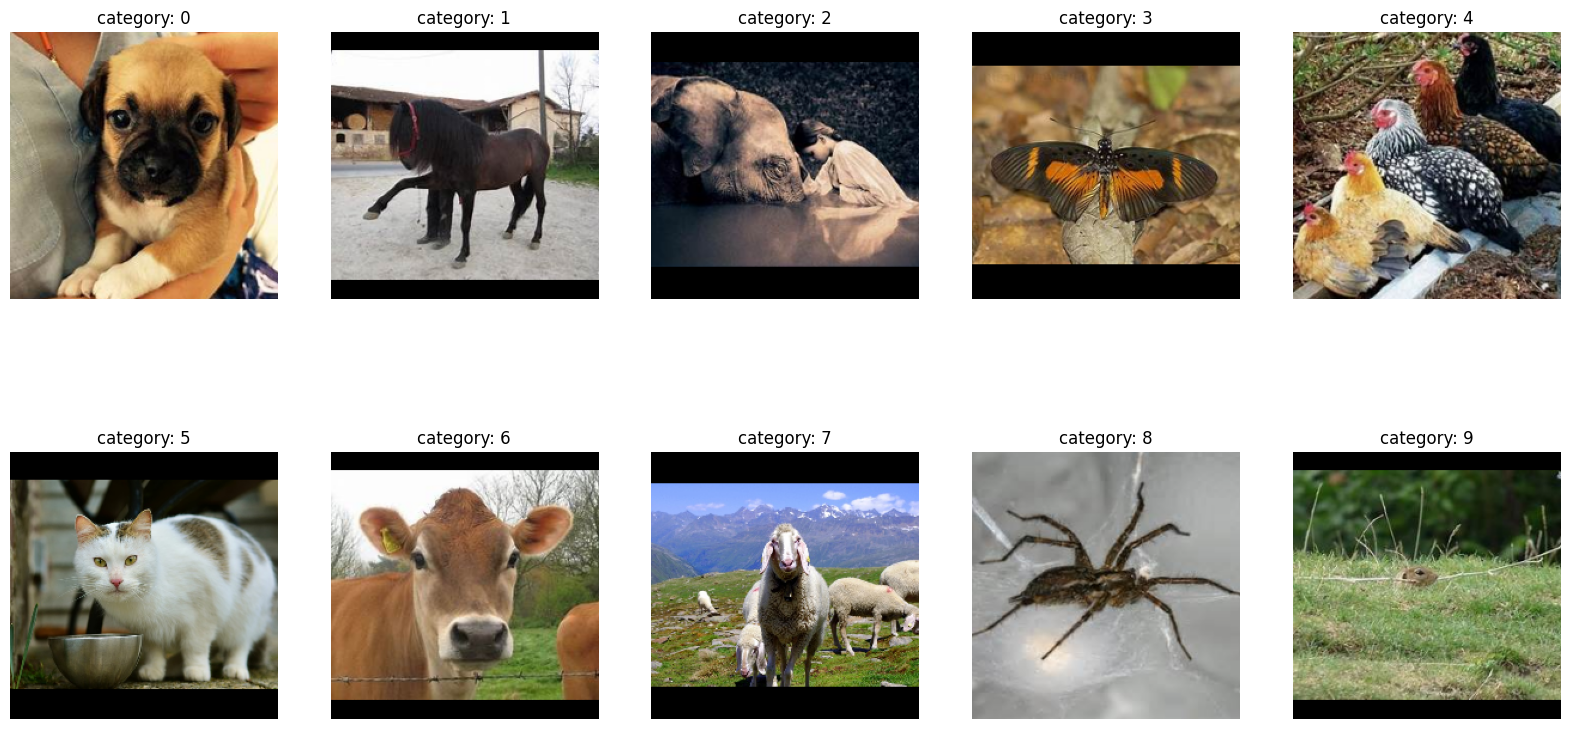

In [10]:
# visualize one image of each category
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    img = images[train_data[train_data['category'] == i].index[0]]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"category: {i}")

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.4 Re-shuffle processed data for optimal training

In [11]:
x_shuffle = []
y_shuffle = []
random_index = np.random.permutation(len(images))

for i in tqdm(range(len(images))):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])

x = np.array(x_shuffle)
y = np.array(y_shuffle)

  0%|          | 0/10000 [00:00<?, ?it/s]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.5 Train-Validation split

In [12]:
train_size = int(len(x) * 0.8)
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}',"\n",
      f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}',"\n",
      f'image shape: {x_train[0].shape}')

x_train shape: (8000, 224, 224, 3), y_train shape: (8000,) 
 x_val shape: (2000, 224, 224, 3), y_val shape: (2000,) 
 image shape: (224, 224, 3)


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.6 Data Augmentation

We apply random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

[Data Augmentation Article](https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)

In [13]:
# create a data generator
train_datagen = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_datagen.fit(x_train)

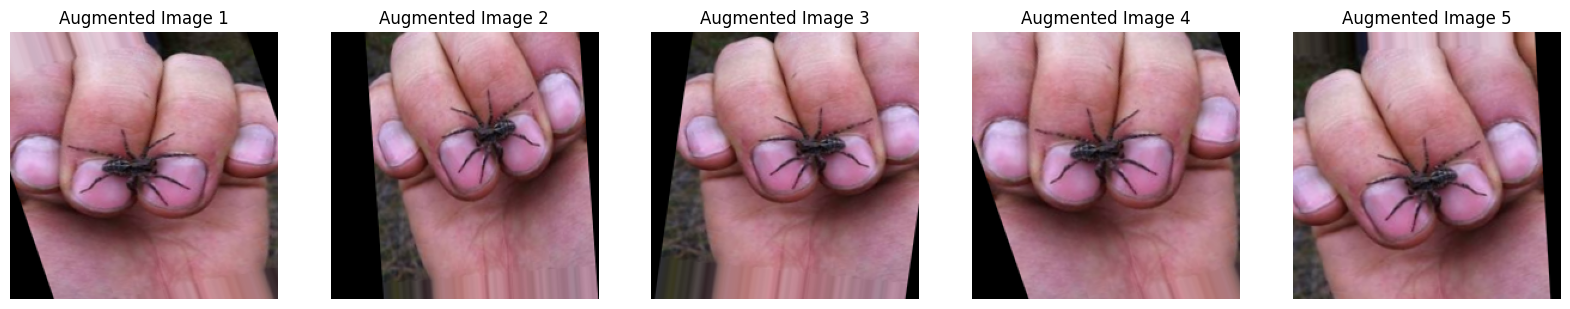

In [14]:
# visualize the transformations made on a single image
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
img = x_train[97] # choose a random image from the training set

# reshape the image to (1, height, width, channels) as the generator expects a batch
img = img.reshape((1,) + img.shape)

# generate batches of augmented images
augmented_images = train_datagen.flow(img)

for i, ax in enumerate(axes.flat):
    # get the next augmented image
    augmented_image = next(augmented_images)[0].astype('uint8')
    ax.imshow(augmented_image)
    ax.axis('off')
    ax.set_title(f"Augmented Image {i+1}")

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.7 Preprocessing test data

In [15]:
df.head()

,imagefile,category
0,2/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0
1,2/raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS....,0
2,2/raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA....,0
3,2/raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....,0
4,2/raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....,0


In [16]:
# define test data
test_data = []
actual_category =[]

for i in tqdm(range(10)):
    category_data = df[df['category'] == i]
    test_data.append(category_data.iloc[1001:1005, :1])
    actual_category.append(category_data.iloc[1001:1005, 1:])

test_data = pd.concat(test_data, ignore_index=True)
actual_category = pd.concat(actual_category, ignore_index=True)

test_images = []

# preprocess test images
with tqdm(total=len(test_data)) as k:
    for i, file_path in enumerate(test_data['imagefile']):
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if img.shape[0] > img.shape[1]:
            tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        img = centering_img(cv2.resize(img, dsize=tile_size))
        img = img[16:240, 16:240]
        test_images.append(img)
        k.update(1)

test_images = np.array(test_images).reshape(-1, 224, 224, 3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

3. Developing Neural Networks

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1 VGG-16 Model

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Geeks for Geeks article on VGG-166](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

In [17]:
lr = 0.001
epochs = 25
momentum = 0.8
sgd = optimizers.SGD(learning_rate=lr, 
                     momentum=momentum,
                     nesterov=False)

# load the pre-trained model
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze the base model
base_model.trainable = False

# add a custom classifier
model = Sequential()
model.add(Flatten(input_shape=base_model.output_shape[1:])) # the VGG-16 model has a 3D output shape but dense layer expects 1D input
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# combine the base model and the custom classifier
vgg16_model = Model(inputs=base_model.input, outputs=model(base_model.output))

# compile the model
vgg16_model.compile(optimizer=sgd, 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

vgg16_model.summary()


c:\Users\agbad\newenv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 10)             │     6,425,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2 ResNet50 Model

In [20]:
lr = 0.001
epochs = 25
momentum = 0.8
sgd = optimizers.SGD(learning_rate=lr, 
                     momentum=momentum,
                     nesterov=False)

# load the pre-trained model
base_model1 = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# freeze the base model
base_model1.trainable = False

# add a custom classifier
model1 = Sequential()
model1.add(Flatten(input_shape=base_model1.output_shape[1:]))
model1.add(tf.keras.layers.Dense(256, activation='relu'))
model1.add(tf.keras.layers.Dense(10, activation='softmax'))

# combine the base model and the custom classifier
resnet50_model = Model(inputs=base_model1.input, outputs=model1(base_model1.output))

# compile the model
resnet50_model.compile(optimizer=sgd, 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

resnet50_model.summary()

c:\Users\agbad\newenv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,280,650 (187.99 MB)

 Trainable params: 25,692,938 (98.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3 Model Training

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; > **VGG16**

In [23]:
batch_size =32 
epochs = 25  
neural_ntwk1 = vgg16_model.fit(train_datagen.flow(x_train, y_train,
                                        batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    epochs=epochs,validation_data=(x_val, y_val),
                    callbacks=[ModelCheckpoint('VGG16-transferlearning.keras',
                               monitor='val_acc')])

c:\Users\agbad\newenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 4551s 18s/step - accuracy: 0.5530 - loss: 5.8702 - val_accuracy: 0.8395 - val_loss: 0.5798
Epoch 2/25


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2288.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


250/250 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8395 - val_loss: 0.5798
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 16772s 67s/step - accuracy: 0.8051 - loss: 0.6124 - val_accuracy: 0.8490 - val_loss: 0.5484
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8490 - val_loss: 0.5484
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2213s 9s/step - accuracy: 0.8454 - loss: 0.4906 - val_accuracy: 0.9010 - val_loss: 0.3980
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9010 - val_loss: 0.3980
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2426s 10s/step - accuracy: 0.8692 - loss: 0.4034 - val_accuracy: 0.9025 - val_loss: 0.3910
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9025 - val_loss: 0.3910
Epoch 9/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2569s 10s/step - accuracy: 0.8

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; > **ResNet50**

In [25]:
batch_size =32
epochs = 30
neural_ntwk2= resnet50_model.fit(train_datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    validation_data=(x_val, y_val),epochs=epochs,
                    callbacks=[ModelCheckpoint ('ResNet50transferlearning.keras',
                               monitor='val_acc')])

c:\Users\agbad\newenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 953s 4s/step - accuracy: 0.1047 - loss: 172.6591 - val_accuracy: 0.0960 - val_loss: 2.3026
Epoch 2/30


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2288.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


250/250 ━━━━━━━━━━━━━━━━━━━━ 174s 695ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0960 - val_loss: 2.3026
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1002s 4s/step - accuracy: 0.1045 - loss: 2.3033 - val_accuracy: 0.0960 - val_loss: 2.3027
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 188s 753ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0960 - val_loss: 2.3027
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 794s 3s/step - accuracy: 0.0989 - loss: 2.3026 - val_accuracy: 0.0960 - val_loss: 2.3028
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 540ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0960 - val_loss: 2.3028
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 851s 3s/step - accuracy: 0.1003 - loss: 2.3025 - val_accuracy: 0.0960 - val_loss: 2.3029
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 160s 640ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0960 - val_loss: 2.3029
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 845s 3s/step - accuracy

KeyboardInterrupt: 